In [1]:
# Importing the required libaries

import os
import warnings
from typing import Dict
from typing import List
from typing import Literal
from datetime import datetime

import sqlite3
from tqdm import tqdm
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Configurations for libraries

tqdm.pandas()
warnings.filterwarnings("ignore")

In [3]:
mode: Literal["local", "colab"] = "local"

if mode == "colab":
    from google.colab import drive
    
    # Mounting Google Drive to Colab runtime
    drive.mount("/content/MyDrive")

    # Changing working directory to project directory
    print(f"Current Working Directory: {os.getcwd()}")

    print("Changing the directory to the project root directory...")
    os.chdir("/content/MyDrive/MyDrive/FAI - Project")
    
    print(f"Current Working Directory: {os.getcwd()}")

In [4]:
DATA_DIR = "../data"

DATA_URL = os.path.join(DATA_DIR, "fai_project_data.csv")

df = pd.read_csv(DATA_URL)

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
0,2022-11-29,143.487983,144.005097,139.569896,140.385330,83763800,0.0,0.0,AAPL,"Stock Market Rally Awaits Fed Chief Powell, Ke..."
1,2022-11-30,140.614017,147.893336,139.768751,147.207169,111380900,0.0,0.0,AAPL,Elon Musk says Apple never considered removing...
2,2022-12-01,147.386191,148.301076,145.795079,147.485626,71250400,0.0,0.0,AAPL,Coinbase says Apple forced it to remove NFT wa...
3,2022-12-02,145.148696,147.177350,144.840406,146.988403,65447400,0.0,0.0,AAPL,Weekly Roundup | Apple (AAPL) Dips More Than B...
4,2022-12-05,146.948635,150.081120,144.959752,145.814972,68826400,0.0,0.0,AAPL,China’s protests made ‘enough of impact on par...


## Exploratory Data Analysis

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ExploratoryDataAnalyzer(object):
    """
    ExploratoryDataAnalyzer class is used for performing exploratory
    data analysis on the stock market data.
    """

    def __init__(self, stock_name: str, stock_data: pd.DataFrame):
        """
        Constructor to initialize ExploratoryDataAnalyzer object.

        Args:
            stock_name (str): Name of the stock.
            stock_data (pd.DataFrame): DataFrame containing stock data.
        """
        
        self.stock_name = stock_name
        self.stock_data = stock_data

    def plot_close_and_volume(self):
        """
        Method used for plotting the close and
        volume of stock data.
        """
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 8))

        axs[0].plot(self.stock_data["Close"])
        axs[0].set_xlabel("Date")
        axs[0].set_ylabel("Stock Price in $")
        axs[0].set_title(f"Closing stock price of {self.stock_name}, Inc for the past 1 year")

        axs[1].plot(self.stock_data["Volume"])
        axs[1].set_xlabel("Date")
        axs[1].set_ylabel("Volume of stocks traded")
        axs[1].set_title(f"Daily Volume of {self.stock_name} stock traded for the past 1 year")

        fig.suptitle(f"{self.stock_name} stock performance for the past 1 year")

    def perform_eda(self) -> None:
        """
        Method prints out the common descriptive analysis
        done on a tabular dataset.
        """
        
        print("Descriptive Statistics:\n")
        print(self.stock_data.describe().to_markdown())

        print("Information about the dataset:\n")
        print(self.stock_data.info())

        print("Number of null values in the dataset:\n")
        print(self.stock_data.isnull().sum())
        print()

        print(f"Number of duplicate values: {self.stock_data.duplicated().sum()}")


class NaiveTimeSeriesModels(object):
    """
    NaiveTimeSeriesModels class fits naive time series models
    to the stock market data.
    """

    def __init__(self, stock_name: str, stock_data: pd.DataFrame):
        """
        Constructor to initialize NaiveTimeSeriesModels object.

        Args:
            stock_name (str): Name of the stock.
            stock_data (pd.DataFrame): DataFrame containing stock data.
        """
        
        self.stock_name = stock_name
        self.stock_data = stock_data

    @staticmethod
    def __round(x, precision=2):
        """
        Helper method to round a number.

        Args:
            x: Number to be rounded.
            precision (int): Number of decimal places.

        Returns:
            Rounded number.
        """
        
        return np.round(x, precision)

    def calculate_metrics(self, y_true, y_pred) -> Dict[str, float]:
        """
        Helper method used to calculate the metrics for
        evaluating the performance of naive time series models.

        Args:
            y_true: True values.
            y_pred: Predicted values.

        Returns:
            Dict[str, float]: Dictionary containing calculated metrics.
        """
        
        metrics = {}
        metrics["MAE"] = self.__round(mean_absolute_error(y_true, y_pred))
        metrics["MSE"] = self.__round(mean_squared_error(y_true, y_pred))
        return metrics

    def train_moving_average_model(self, ma_days: List[int] = [10, 15, 30]) -> None:
        """
        Method used to fit a moving average model
        on the stock market time series dataset.

        Args:
            ma_days (List[int]): List of window sizes for moving averages.
        """
        
        column_name = "Close"
        plot_cols = [column_name]

        plt.figure(figsize=(12, 8))
        plt.plot(self.stock_data[column_name], label="Closing Price")

        for ma_day in ma_days:
            column_name = f"Moving Avg for {ma_day} days"
            plot_cols.append(column_name)

            mean_avg = self.stock_data['Close'].rolling(ma_day).mean()
            self.stock_data.loc[:, column_name] = mean_avg

            # Some of the rows based on their index would have nan values in the moving
            # average column, we have to remove them.
            nan_idx = self.stock_data.loc[pd.isna(self.stock_data[column_name]), :].index
            self.stock_data_nonna = self.stock_data.drop(index=nan_idx)
            mean_avg_nonna = mean_avg.drop(index=nan_idx)

            y_true = self.stock_data_nonna["Close"]
            y_pred = mean_avg_nonna

            metrics = self.calculate_metrics(y_true, y_pred)

            print(f"Metrics for {column_name}:")
            print(metrics)

            print()

            plt.plot(self.stock_data[column_name], label=column_name)

        plt.legend()
        plt.show()

#### 1. Apple Inc. (AAPL)

In [6]:
aapl_df = df[df["Ticker"] == "AAPL"]
aapl_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
0,2022-11-29,143.487983,144.005097,139.569896,140.385330,83763800,0.0,0.0,AAPL,"Stock Market Rally Awaits Fed Chief Powell, Ke..."
1,2022-11-30,140.614017,147.893336,139.768751,147.207169,111380900,0.0,0.0,AAPL,Elon Musk says Apple never considered removing...
2,2022-12-01,147.386191,148.301076,145.795079,147.485626,71250400,0.0,0.0,AAPL,Coinbase says Apple forced it to remove NFT wa...
3,2022-12-02,145.148696,147.177350,144.840406,146.988403,65447400,0.0,0.0,AAPL,Weekly Roundup | Apple (AAPL) Dips More Than B...
4,2022-12-05,146.948635,150.081120,144.959752,145.814972,68826400,0.0,0.0,AAPL,China’s protests made ‘enough of impact on par...


In [7]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Apple, Inc", stock_data=aapl_df)
data_analyser.perform_eda()

Descriptive Statistics:

|       |     Open |    High |      Low |    Close |        Volume |    Dividends |   Stock Splits |
|:------|---------:|--------:|---------:|---------:|--------------:|-------------:|---------------:|
| count | 242      | 242     | 242      | 242      | 242           | 242          |            242 |
| mean  | 165.962  | 167.633 | 164.574  | 166.201  |   6.25378e+07 |   0.00392562 |              0 |
| std   |  18.5328 |  18.371 |  18.6866 |  18.5203 |   1.87102e+07 |   0.0303486  |              0 |
| min   | 125.31   | 127.06  | 123.48   | 124.325  |   3.14582e+07 |   0          |              0 |
| 25%   | 150.602  | 152.798 | 149.594  | 151.01   |   4.98301e+07 |   0          |              0 |
| 50%   | 171.593  | 172.88  | 170.485  | 171.673  |   5.78806e+07 |   0          |              0 |
| 75%   | 179.243  | 180.357 | 177.122  | 179.118  |   6.96193e+07 |   0          |              0 |
| max   | 195.718  | 197.702 | 194.76   | 195.927  |   1.60157e+08

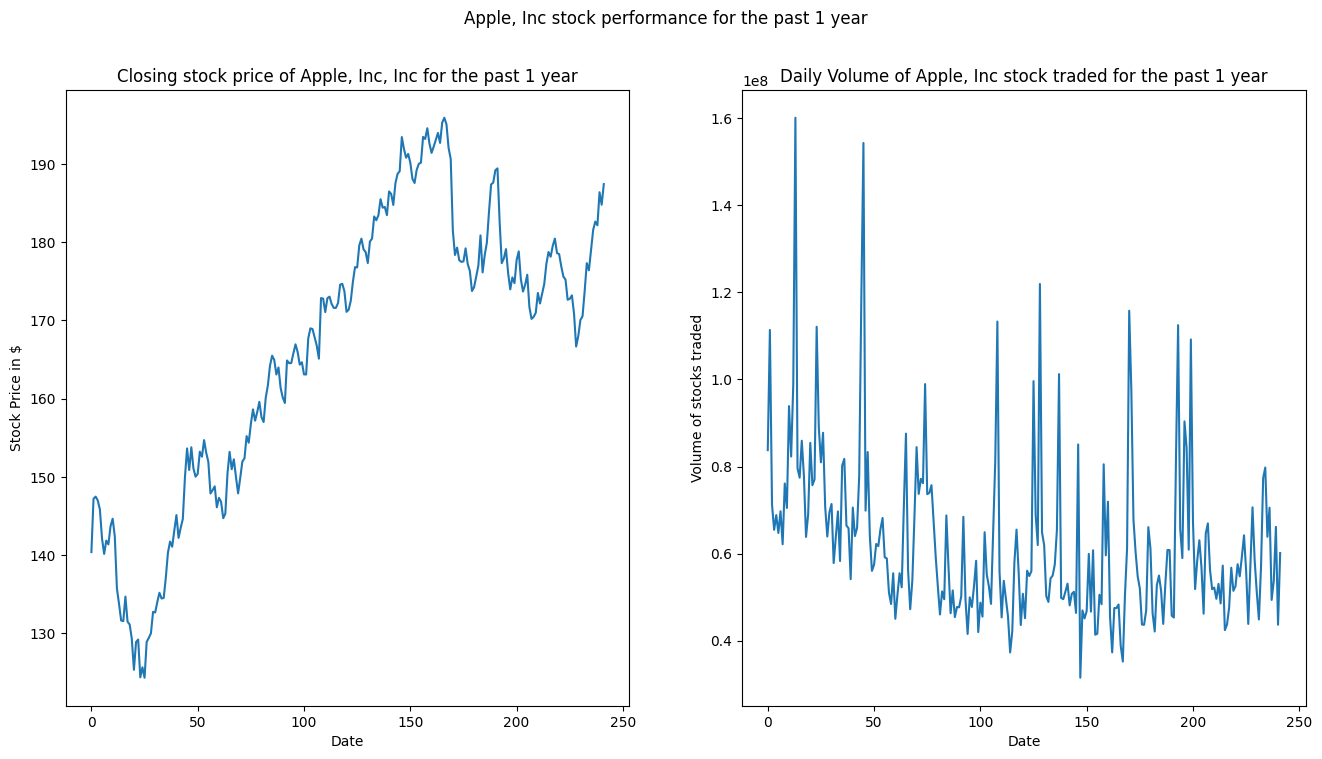

In [8]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 3.4, 'MSE': 16.95}

Metrics for Moving Avg for 15 days:
{'MAE': 4.44, 'MSE': 27.73}

Metrics for Moving Avg for 30 days:
{'MAE': 6.1, 'MSE': 50.45}



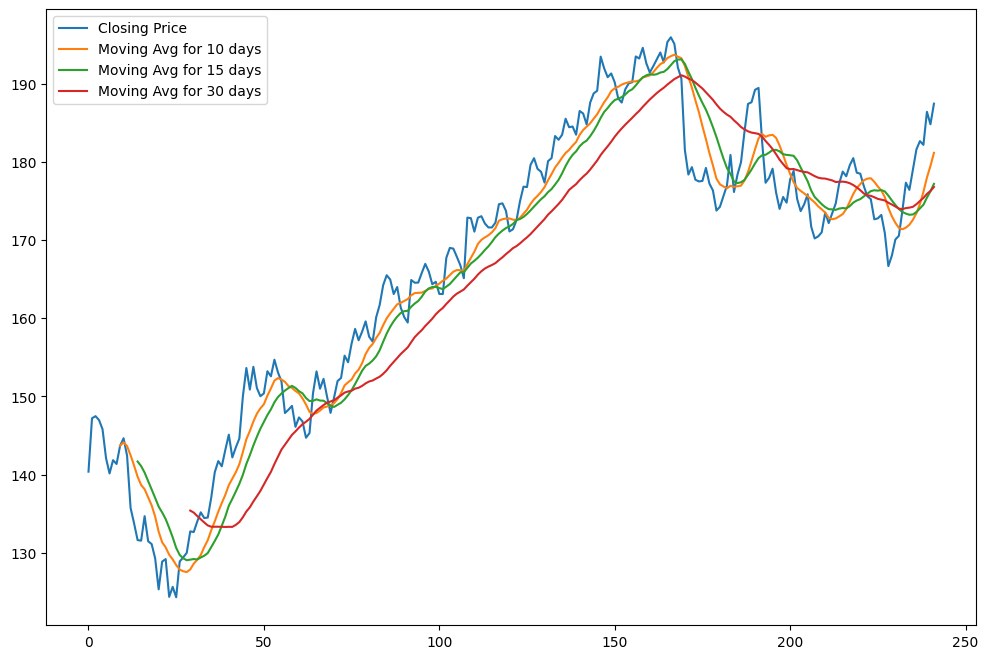

In [9]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Apple, Inc", stock_data=aapl_df)
naive_ts_models.train_moving_average_model()

#### 2. Airbnb, Inc. (ABNB)

In [10]:
abnb_df = df[df["Ticker"] == "ABNB"]
abnb_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
242,2022-11-30,95.860001,102.250000,95.720001,102.139999,8387500,0.0,0.0,ABNB,New Airbnb feature will match landlords and ho...
243,2022-12-01,101.489998,102.760002,99.550003,101.269997,5040300,0.0,0.0,ABNB,Airbnb urged to require carbon monoxide device...
244,2022-12-02,99.250000,101.739998,98.970001,101.000000,4128600,0.0,0.0,ABNB,3 Top Tech Stocks to Buy During a Recession | ...
245,2022-12-05,100.000000,101.169998,98.040001,98.510002,3601500,0.0,0.0,ABNB,NYC Spars With Hosts Over New Airbnb Rental La...
246,2022-12-06,98.250000,98.500000,91.900002,93.120003,8380900,0.0,0.0,ABNB,Why Airbnb Stock Fell Today | Why One Analyst ...


In [11]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Airbnb, Inc", stock_data=abnb_df)

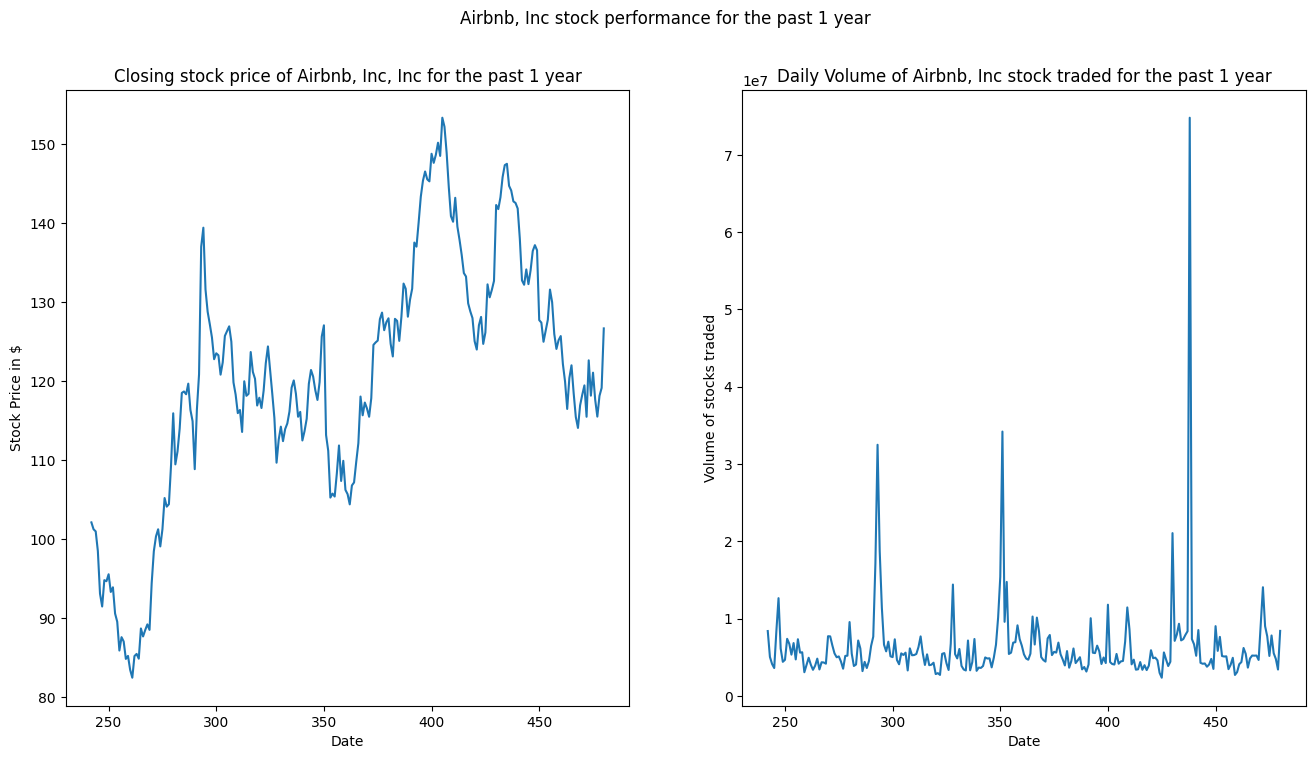

In [12]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 4.5, 'MSE': 30.31}

Metrics for Moving Avg for 15 days:
{'MAE': 5.91, 'MSE': 50.85}

Metrics for Moving Avg for 30 days:
{'MAE': 8.64, 'MSE': 106.63}



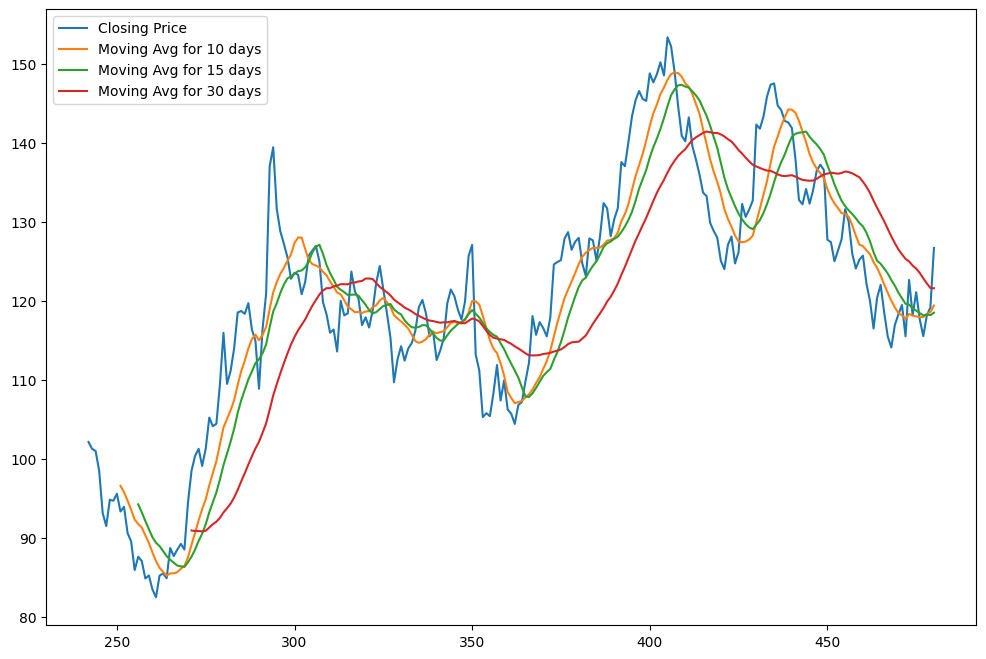

In [13]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Airbnb, Inc", stock_data=abnb_df)
naive_ts_models.train_moving_average_model()

#### 3. Amazon.com, Inc. (AMZN)

In [14]:
amazon_df = df[df["Ticker"] == "AMZN"]
amazon_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
481,2022-11-30,92.470001,96.540001,91.529999,96.540001,102805800,0.0,0.0,AMZN,AWS and Slalom Expand Next-Generation Strategi...
482,2022-12-01,96.989998,97.230003,94.919998,95.500000,68488000,0.0,0.0,AMZN,"Amazon plans to lay off more than 10,000 worke..."
483,2022-12-02,94.480003,95.360001,93.779999,94.129997,72496400,0.0,0.0,AMZN,12 Best Blockchain Stocks To Buy Now | Amazon'...
484,2022-12-05,93.050003,94.059998,90.820000,91.010002,71535500,0.0,0.0,AMZN,"Why Amazon, Okta, and Roku Stocks All Slumped ..."
485,2022-12-06,90.500000,91.040001,87.900002,88.250000,75503600,0.0,0.0,AMZN,12 Best Growth Stocks To Buy According To Geor...


In [15]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Amazon, Inc", stock_data=amazon_df)

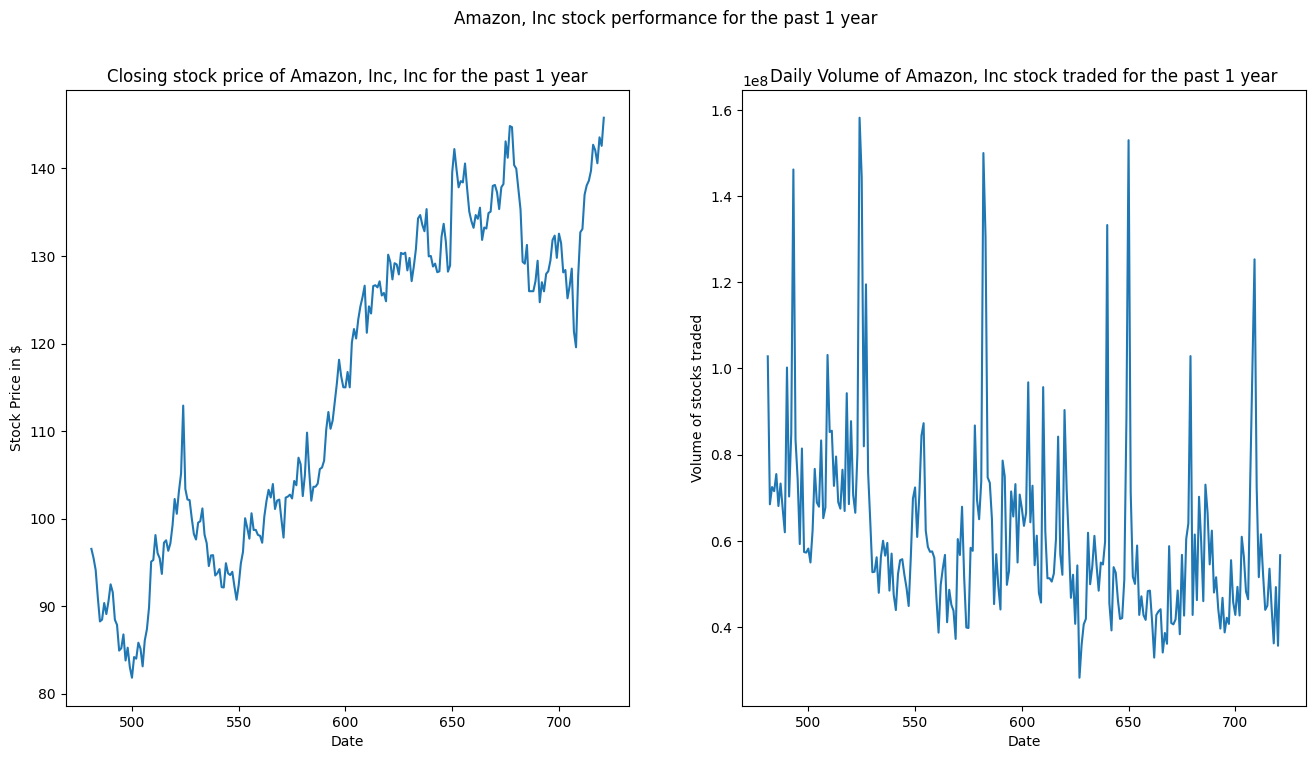

In [16]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 3.05, 'MSE': 14.9}

Metrics for Moving Avg for 15 days:
{'MAE': 3.91, 'MSE': 22.83}

Metrics for Moving Avg for 30 days:
{'MAE': 5.63, 'MSE': 44.46}



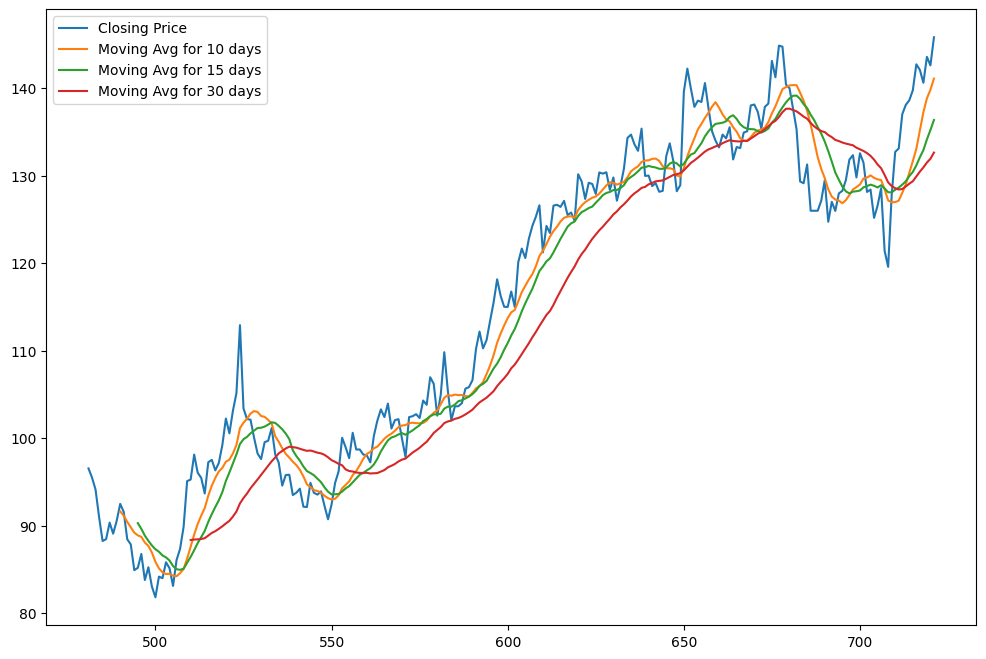

In [17]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Amazon, Inc", stock_data=amazon_df)
naive_ts_models.train_moving_average_model()

#### 4. Coinbase Global, Inc. (COIN)

In [18]:
coinbase_df = df[df["Ticker"] == "COIN"]
coinbase_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
722,2022-11-30,43.709999,45.880001,41.509998,45.730000,15562700,0.0,0.0,COIN,"If you own Bitcoin Cash, XRP, or Ethereum Clas..."
723,2022-12-01,45.820000,47.189999,44.439999,45.270000,11579400,0.0,0.0,COIN,Coinbase says Apple forced it to remove NFT wa...
724,2022-12-02,43.970001,47.700001,43.730000,47.669998,10372100,0.0,0.0,COIN,12 Best Blockchain Stocks To Buy Now | FTX col...
725,2022-12-05,47.980000,49.849998,45.630001,46.000000,11228300,0.0,0.0,COIN,"Crypto insurance is nearly nonexistent, so you..."
726,2022-12-06,45.599998,46.650002,41.730000,42.410000,12156100,0.0,0.0,COIN,The Top (and Bottom) Five Stocks of 2022 | Bit...


In [19]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Coinbase Global, Inc", stock_data=coinbase_df)

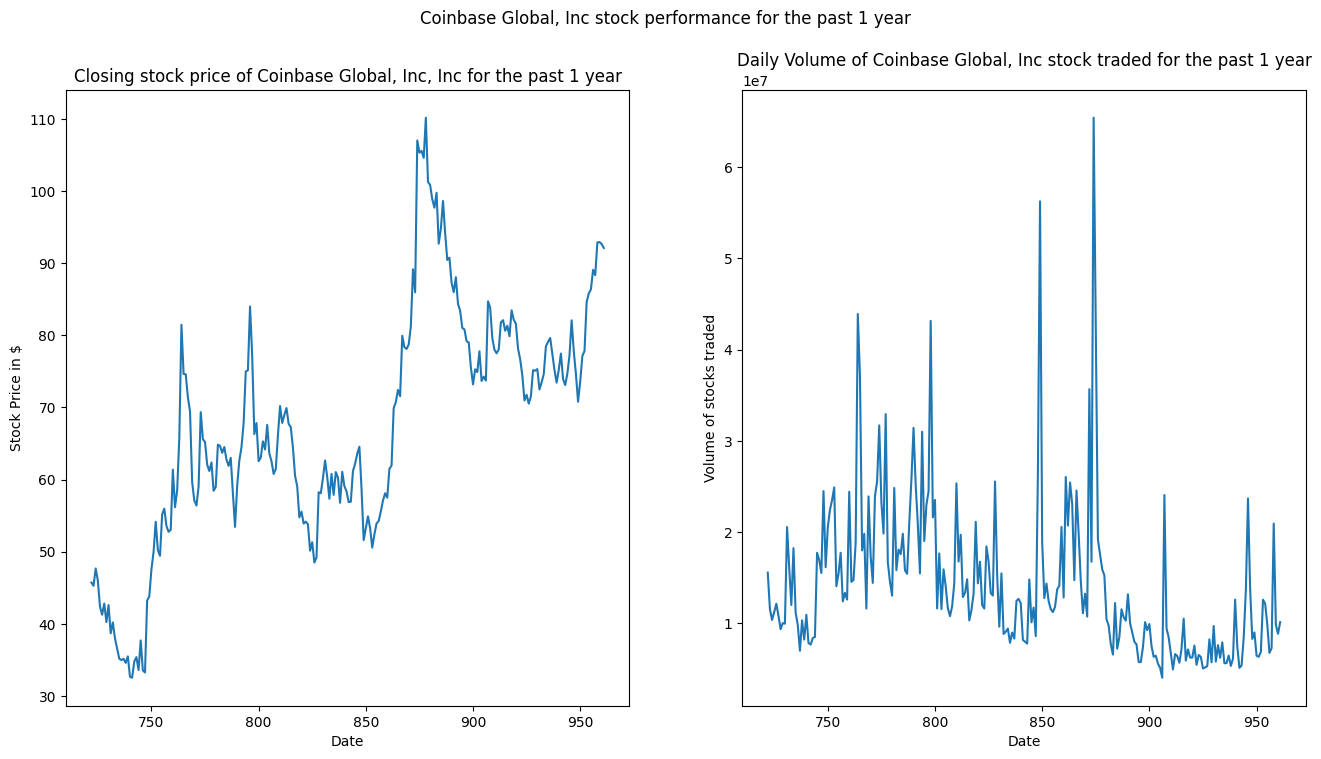

In [20]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 4.87, 'MSE': 39.57}

Metrics for Moving Avg for 15 days:
{'MAE': 6.09, 'MSE': 62.87}

Metrics for Moving Avg for 30 days:
{'MAE': 8.0, 'MSE': 130.23}



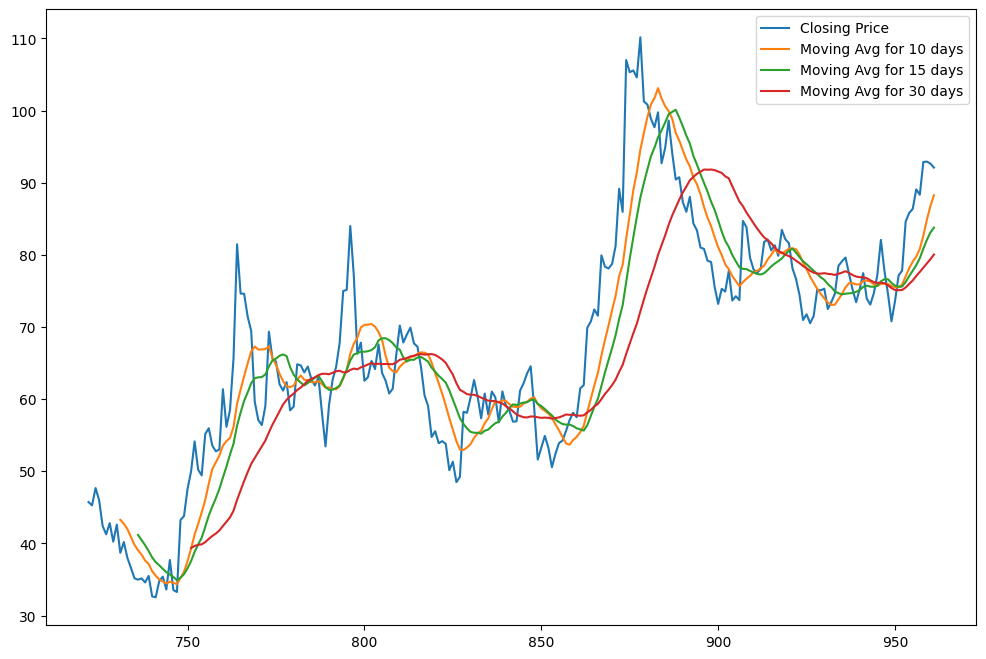

In [21]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Coinbase Global, Inc", stock_data=coinbase_df)
naive_ts_models.train_moving_average_model()

#### 5. Alphabet Inc. (GOOG)

In [22]:
google_df = df[df["Ticker"] == "GOOG"]
google_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
1106,2022-11-30,95.120003,101.449997,94.669998,101.449997,39888100,0.0,0.0,GOOG,YouTube fixes issue after reported outages | G...
1107,2022-12-01,101.400002,102.589996,100.669998,101.279999,21771500,0.0,0.0,GOOG,Does Big Tech Have a Pulse? | How Google's Waz...
1108,2022-12-02,99.370003,101.150002,99.169998,100.830002,18821500,0.0,0.0,GOOG,"Weekly Roundup | Despite Talk Of U.S. Ban, Tik..."
1109,2022-12-05,99.815002,101.750000,99.355003,99.870003,19955500,0.0,0.0,GOOG,UPDATE 1-Facebook owner Meta may remove news f...
1110,2022-12-06,99.669998,100.209999,96.760002,97.309998,20877600,0.0,0.0,GOOG,Alphabet CFO Porat Buys $1.7 Million of Blacks...


In [23]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Google, Inc", stock_data=google_df)

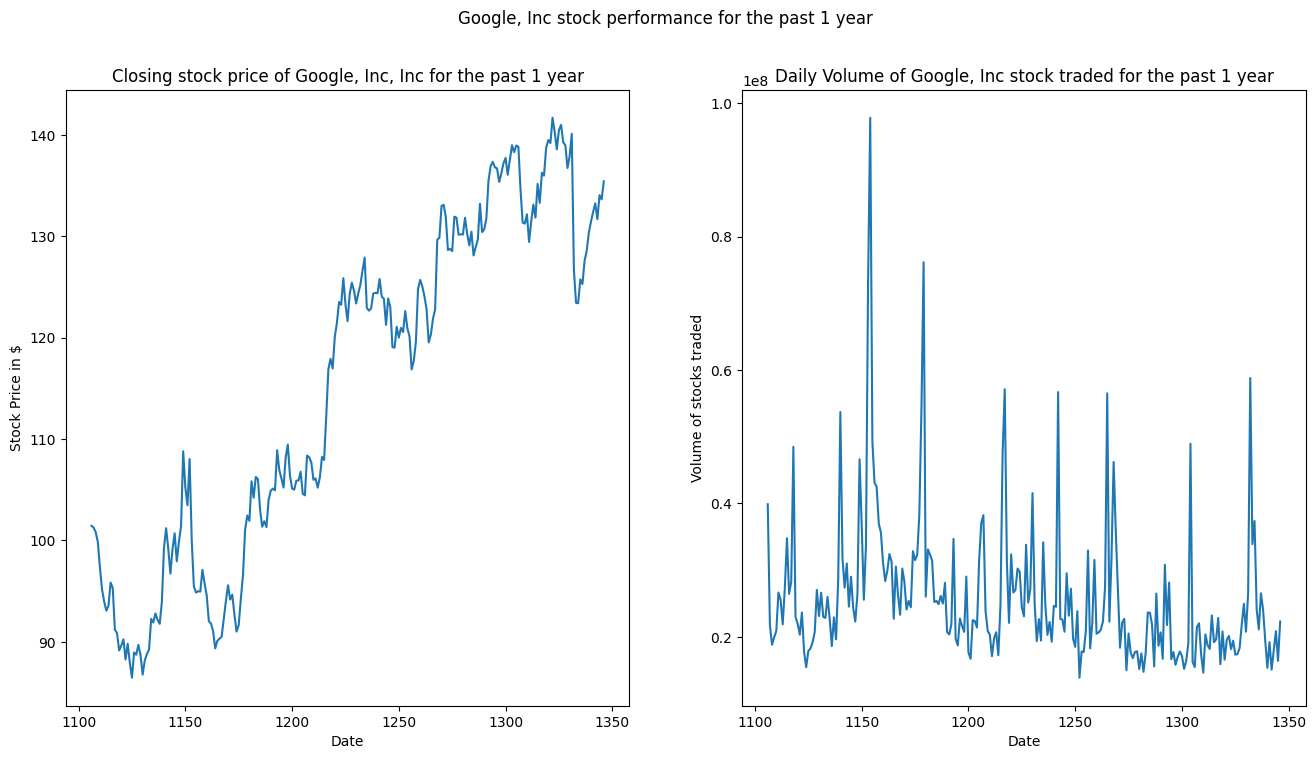

In [24]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 2.8, 'MSE': 13.61}

Metrics for Moving Avg for 15 days:
{'MAE': 3.59, 'MSE': 21.22}

Metrics for Moving Avg for 30 days:
{'MAE': 4.98, 'MSE': 37.29}



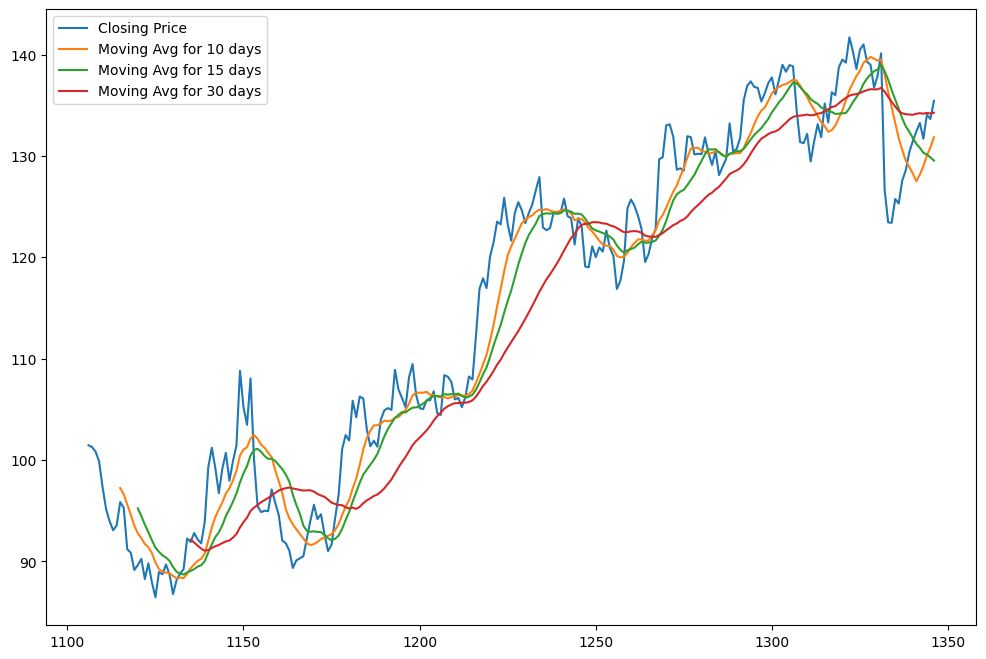

In [25]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Google, Inc", stock_data=google_df)
naive_ts_models.train_moving_average_model()

#### 6. Meta Platforms, Inc. (META)

In [26]:
meta_df = df[df["Ticker"] == "META"]
meta_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
1347,2022-11-30,109.510002,118.160004,109.379997,118.099998,43348600,0.0,0.0,META,Space in Meta-leased Spring District tower app...
1348,2022-12-01,119.199997,121.199997,118.400002,120.440002,36551400,0.0,0.0,META,Apple Renames Mixed-Reality Software ‘xrOS’ in...
1349,2022-12-02,117.830002,124.040001,117.610001,123.489998,39950500,0.0,0.0,META,"Despite Talk Of U.S. Ban, TikTok Keeps Rolling..."
1350,2022-12-05,121.750000,124.669998,121.349998,122.430000,35474900,0.0,0.0,META,UPDATE 1-Facebook owner Meta may remove news f...
1351,2022-12-06,119.910004,120.550003,113.739998,114.120003,43689200,0.0,0.0,META,Why Meta Platforms Stock Dove Today | The easi...


In [27]:
data_analyser = ExploratoryDataAnalyzer(stock_name="META, Inc", stock_data=meta_df)

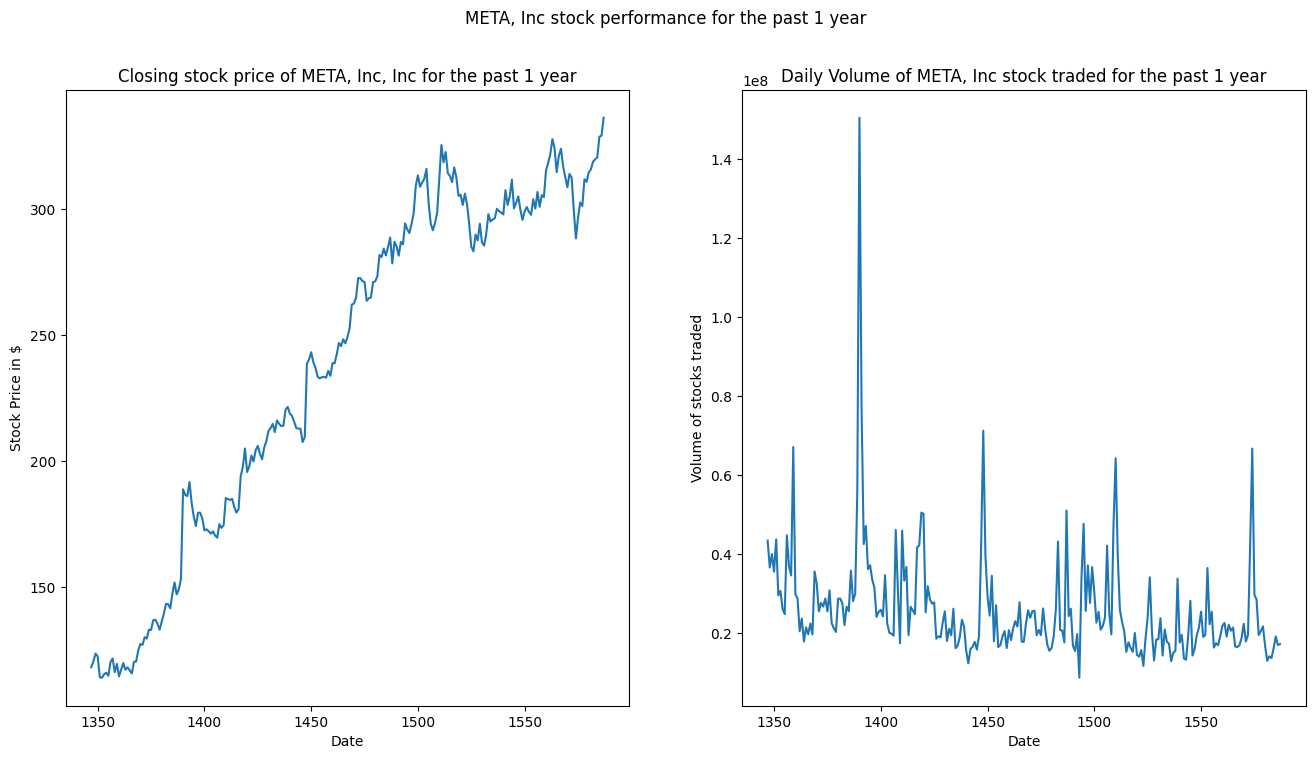

In [28]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 7.23, 'MSE': 86.1}

Metrics for Moving Avg for 15 days:
{'MAE': 9.37, 'MSE': 135.3}

Metrics for Moving Avg for 30 days:
{'MAE': 15.46, 'MSE': 331.39}



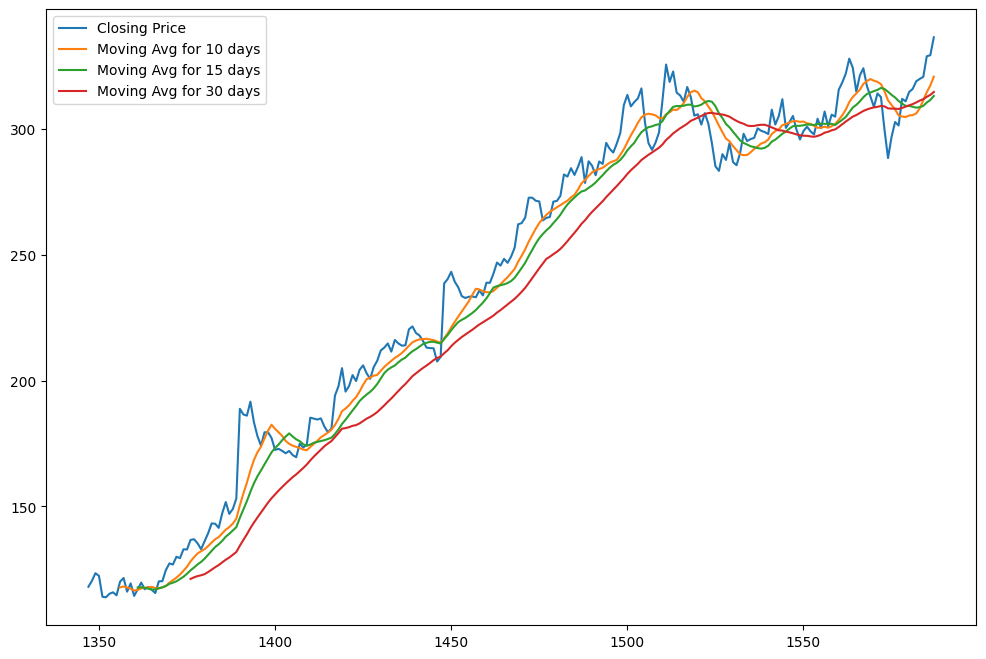

In [29]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="META, Inc", stock_data=meta_df)
naive_ts_models.train_moving_average_model()

#### 7. Moderna, Inc. (MRNA)

In [30]:
moderna_df = df[df["Ticker"] == "MRNA"]
moderna_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
1588,2022-11-30,173.520004,176.750000,169.059998,175.910004,3720200,0.0,0.0,MRNA,REUTERS NEXT-Moderna exec says COVID trials im...
1589,2022-12-01,173.410004,185.899994,172.380005,181.479996,4872000,0.0,0.0,MRNA,"Moderna Stock: Buy, Sell, or Hold in 2023? | M..."
1590,2022-12-02,178.500000,182.800003,177.000000,182.350006,2765400,0.0,0.0,MRNA,BBH: Portfolio Of Large-Cap Biotechnology Stoc...
1591,2022-12-05,180.990005,183.684998,173.589996,175.929993,3525400,0.0,0.0,MRNA,"SPX: The Trend Has Not Been Your Friend, So Wh..."
1592,2022-12-06,175.020004,175.779999,169.699997,173.539993,3392300,0.0,0.0,MRNA,Pfizer accuses Moderna of rewriting history in...


In [31]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Moderna, Inc", stock_data=moderna_df)

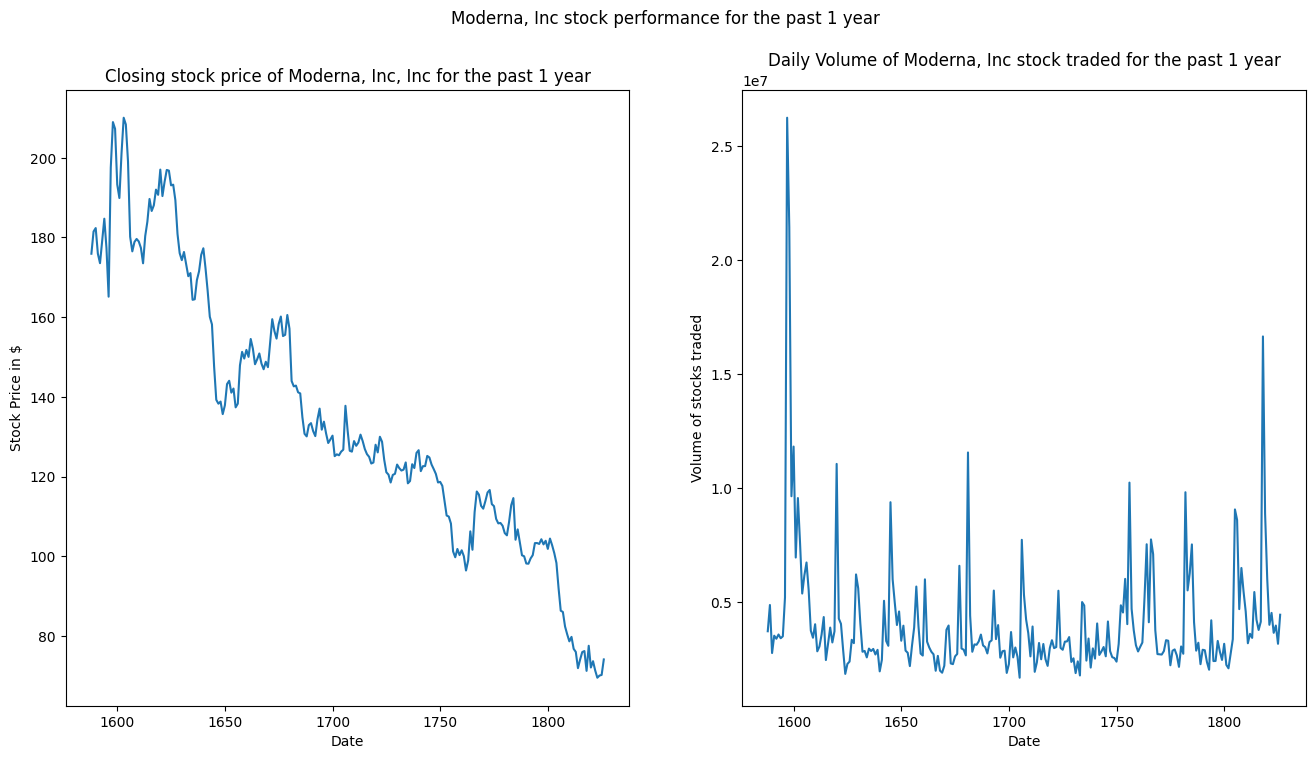

In [32]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 5.74, 'MSE': 58.98}

Metrics for Moving Avg for 15 days:
{'MAE': 6.98, 'MSE': 79.66}

Metrics for Moving Avg for 30 days:
{'MAE': 9.35, 'MSE': 147.55}



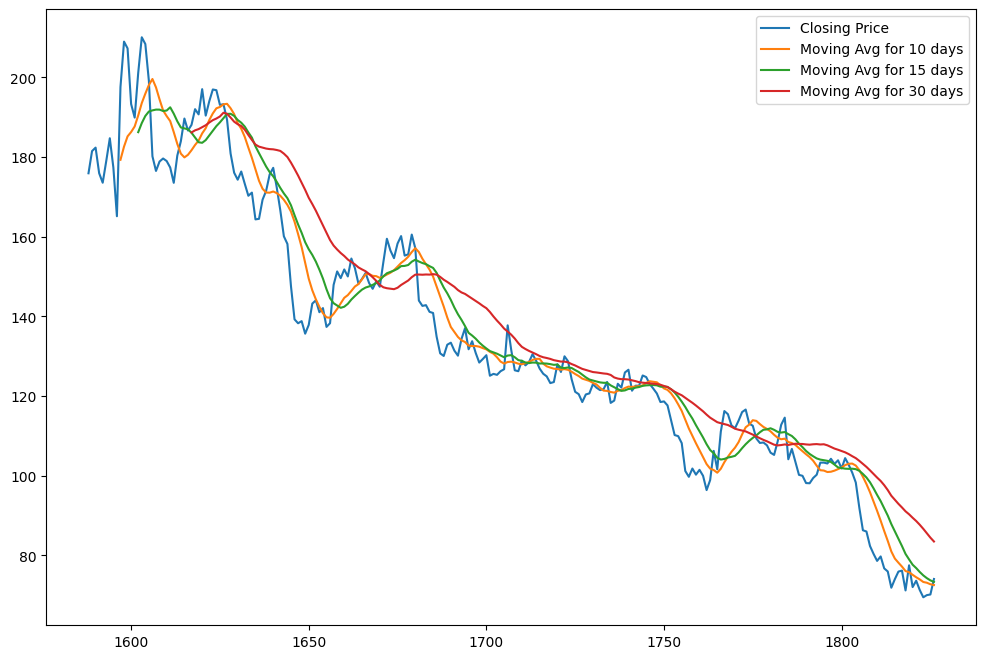

In [33]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Moderna, Inc", stock_data=moderna_df)
naive_ts_models.train_moving_average_model()

#### 8. NVIDIA Corporation (NVDA)

In [34]:
nvidia_df = df[df["Ticker"] == "NVDA"]
nvidia_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
1827,2022-11-30,156.914180,169.239797,155.914536,169.169815,56529800,0.04,0.0,NVDA,Jim Cramer Stock Portfolio: 10 Recent Addition...
1828,2022-12-01,169.929546,172.588588,166.290841,171.289062,47097700,0.00,0.0,NVDA,It's the Wild West in crypto. Does anyone want...
1829,2022-12-02,166.530755,169.269786,164.391517,168.699982,37138900,0.00,0.0,NVDA,"Market Rally Resilient, But This Battle Contin..."
1830,2022-12-05,166.730681,169.889561,164.661425,166.040939,35225500,0.00,0.0,NVDA,11 Best Quality Stocks to Buy Now | Nvidia: Hy...
1831,2022-12-06,165.241218,165.671057,158.133746,159.813141,35269400,0.00,0.0,NVDA,"Apple, AMD confirm they’re among TSMC’s first ..."


In [35]:
data_analyser = ExploratoryDataAnalyzer(stock_name="NVIDIA Corporation", stock_data=nvidia_df)

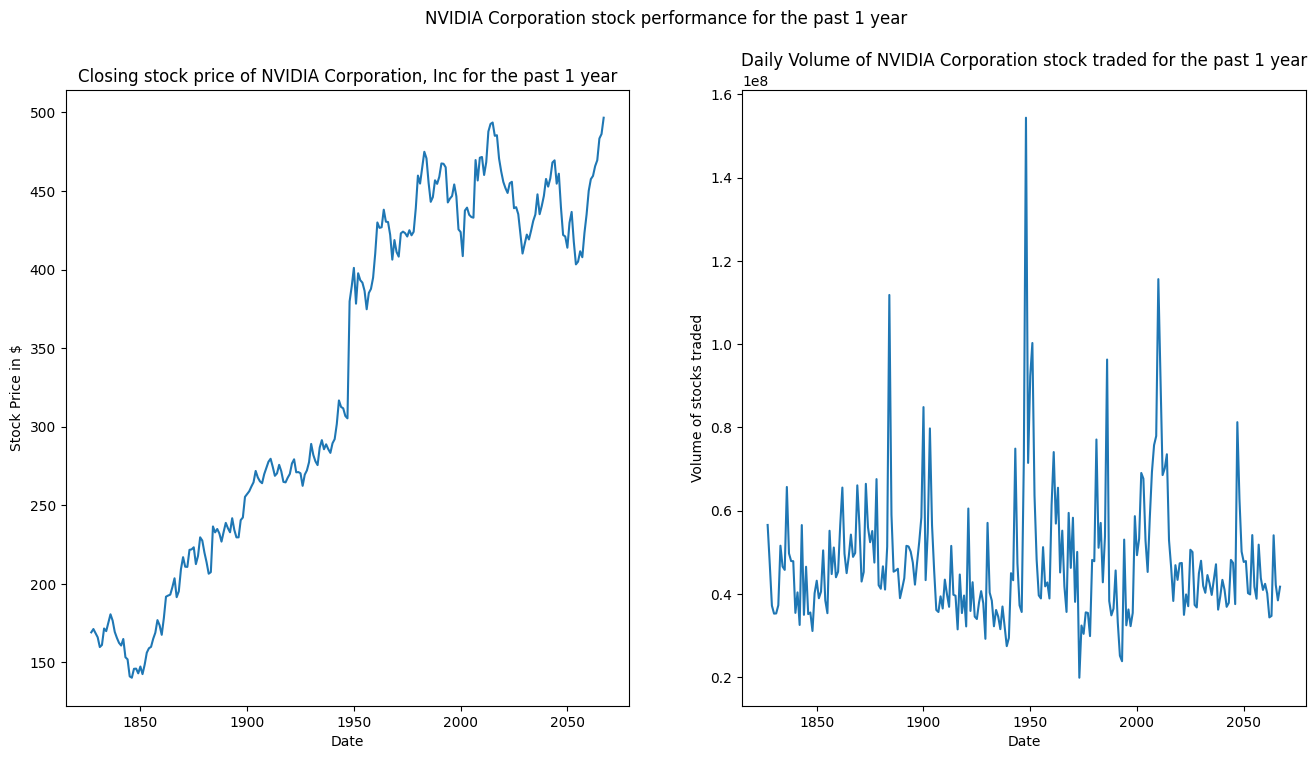

In [36]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 13.64, 'MSE': 322.21}

Metrics for Moving Avg for 15 days:
{'MAE': 17.96, 'MSE': 526.53}

Metrics for Moving Avg for 30 days:
{'MAE': 26.55, 'MSE': 1121.73}



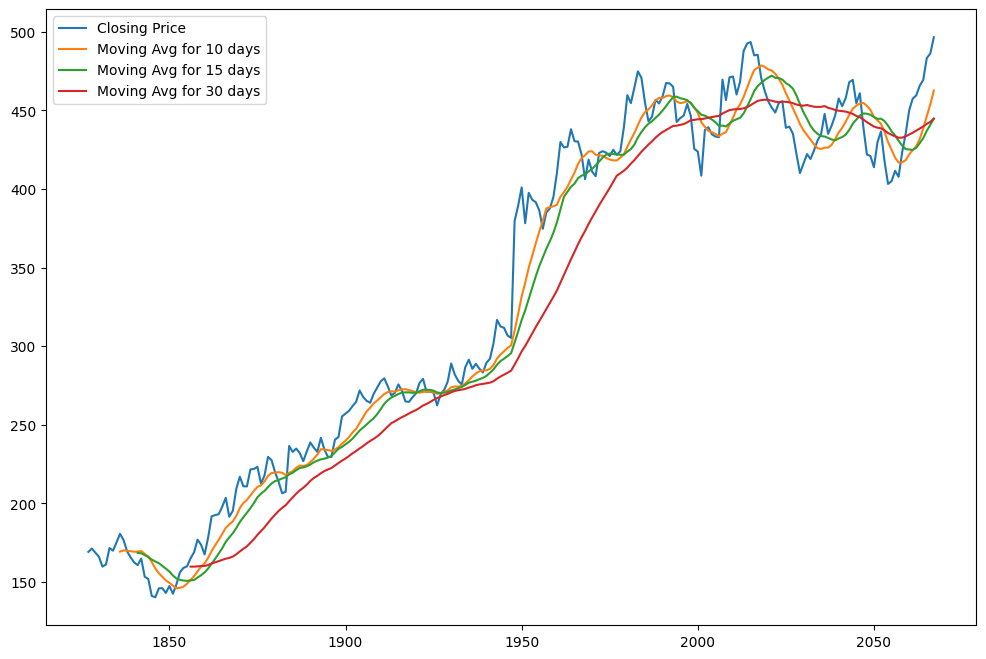

In [37]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="NVIDIA Corporation", stock_data=nvidia_df)
naive_ts_models.train_moving_average_model()

#### 9. Palantir Technologies Inc. (PLTR)

In [38]:
pltr_df = df[df["Ticker"] == "PLTR"]
pltr_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
2068,2022-11-30,7.140,7.510,7.033,7.50,32745700,0.0,0.0,PLTR,Palantir And Lockheed Martin Partner To Improv...
2069,2022-12-01,7.510,7.880,7.470,7.86,34424400,0.0,0.0,PLTR,Why Palantir Technologies Stock Rallied on Thu...
2070,2022-12-02,7.615,7.760,7.500,7.66,18794000,0.0,0.0,PLTR,"Palantir Technologies Inc. stock falls Friday,..."
2071,2022-12-05,7.620,7.695,7.105,7.19,32158200,0.0,0.0,PLTR,"Palantir Technologies Inc. stock falls Monday,..."
2072,2022-12-06,7.190,7.195,6.880,6.99,32868100,0.0,0.0,PLTR,Palantir Technologies Inc. stock falls Tuesday...


In [39]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Palantir Technologies, Inc", stock_data=pltr_df)

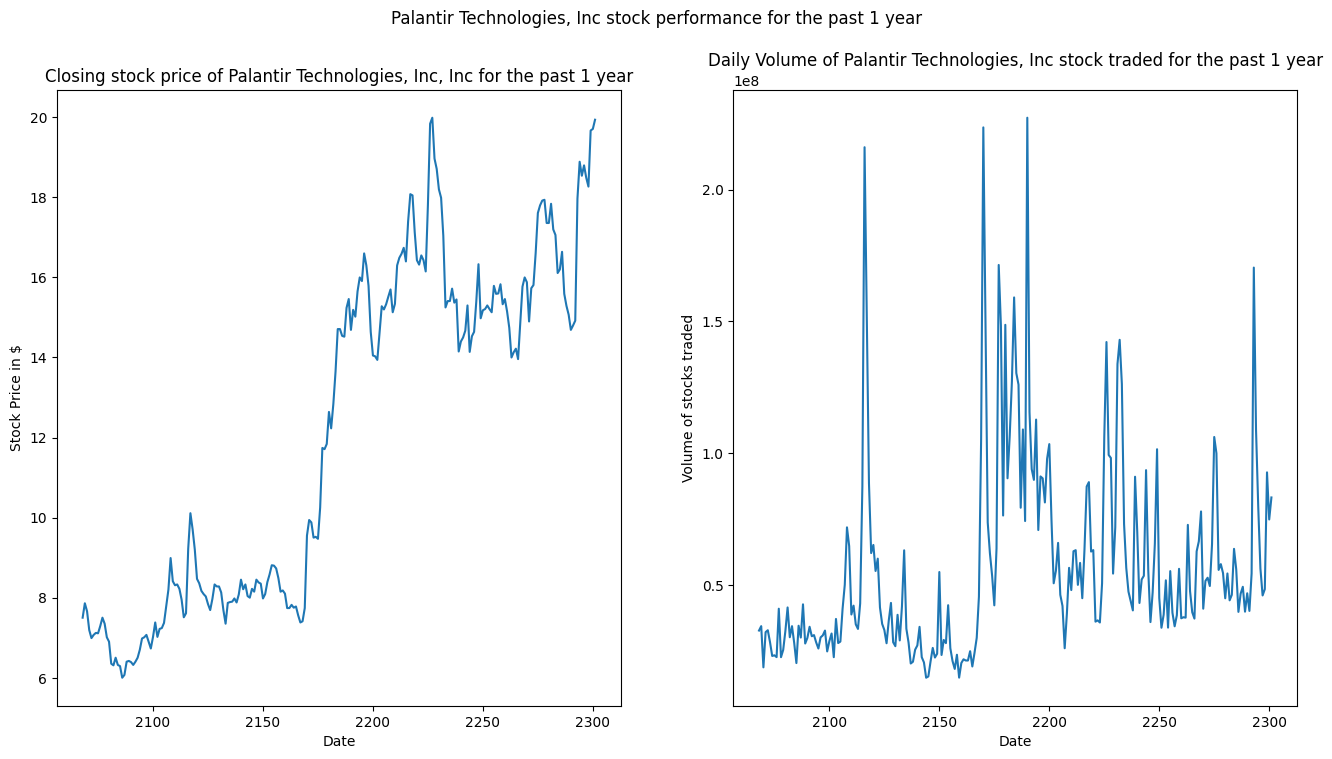

In [40]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 0.76, 'MSE': 1.0}

Metrics for Moving Avg for 15 days:
{'MAE': 0.95, 'MSE': 1.55}

Metrics for Moving Avg for 30 days:
{'MAE': 1.29, 'MSE': 3.09}



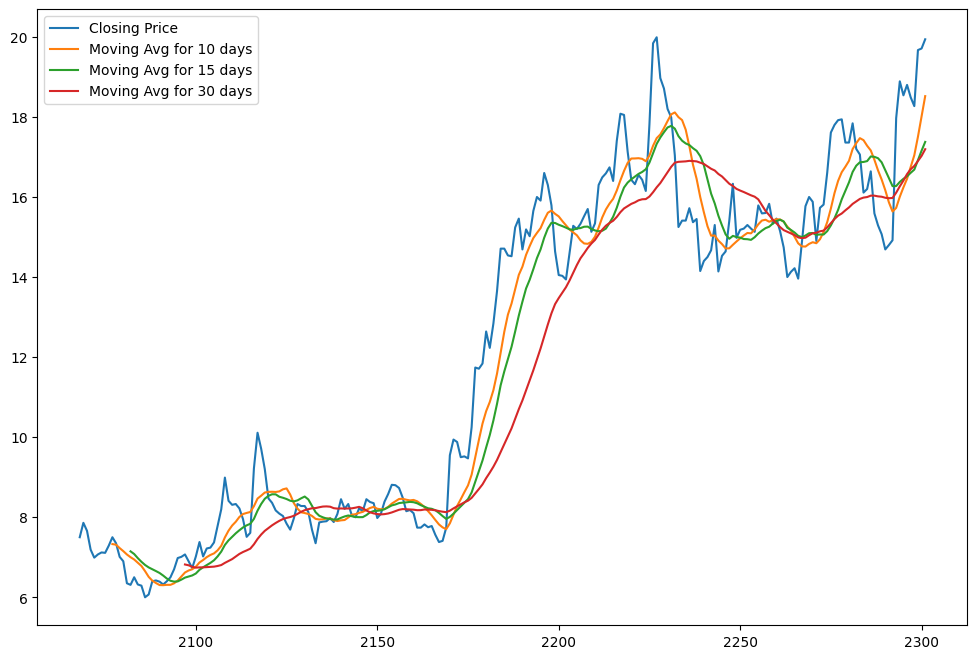

In [41]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Palantir Technologies, Inc", stock_data=pltr_df)
naive_ts_models.train_moving_average_model()

#### 10. Tesla, Inc. (TSLA)

In [42]:
tesla_df = df[df["Ticker"] == "TSLA"]
tesla_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Headlines
2302,2022-11-29,184.990005,186.380005,178.750000,180.830002,83357100,0.0,0.0,TSLA,"Stock Market Rally Awaits Fed Chief Powell, Ke..."
2303,2022-11-30,182.429993,194.759995,180.630005,194.699997,109186400,0.0,0.0,TSLA,Elon Musk says Apple never considered removing...
2304,2022-12-01,197.080002,198.919998,191.800003,194.699997,80046200,0.0,0.0,TSLA,"Brain implants, dark conspiracies, and digital..."
2305,2022-12-02,191.779999,196.250000,191.110001,194.860001,73645900,0.0,0.0,TSLA,Tesla’s New Semi Is Here. 6 Things to Know. | ...
2306,2022-12-05,189.440002,191.270004,180.550003,182.449997,93122700,0.0,0.0,TSLA,Dow Jones Dives As Investors Fear More Rate Hi...


In [43]:
data_analyser = ExploratoryDataAnalyzer(stock_name="Tesla, Inc", stock_data=tesla_df)

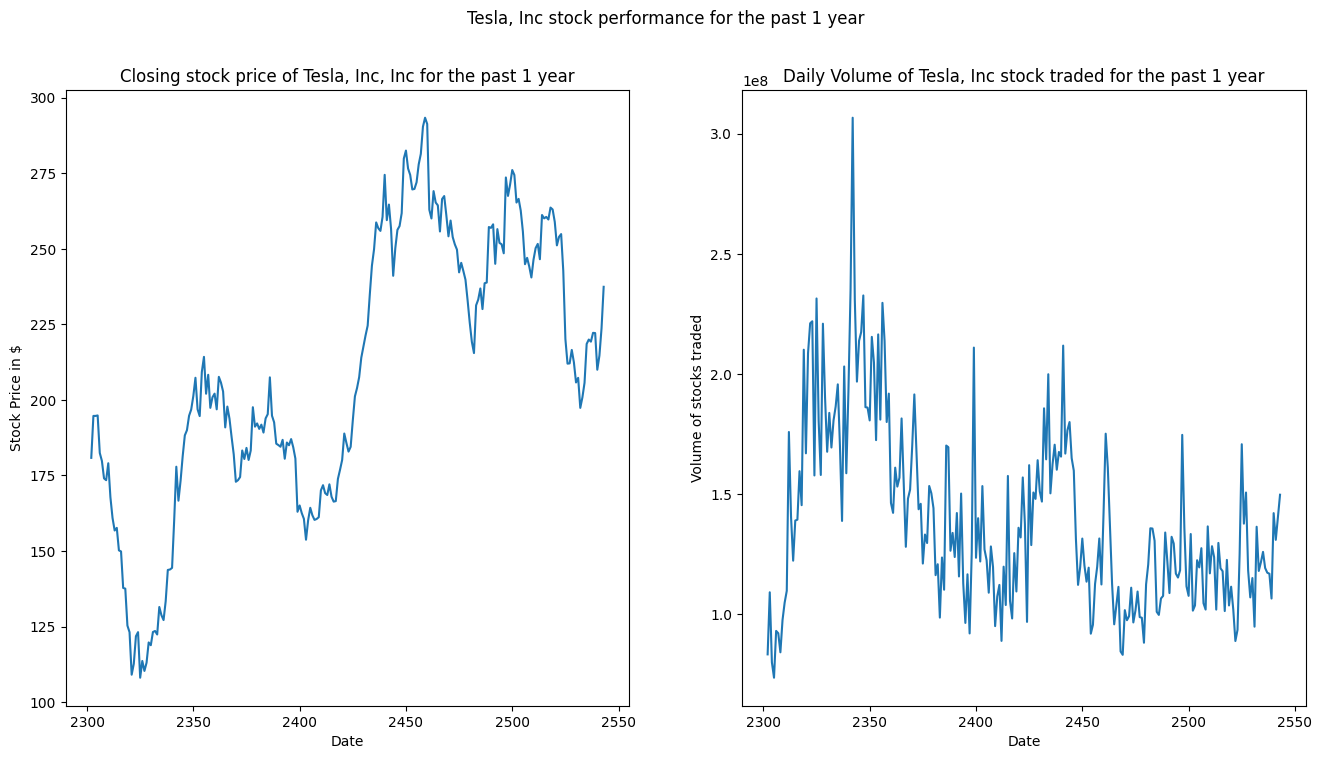

In [44]:
data_analyser.plot_close_and_volume()

Metrics for Moving Avg for 10 days:
{'MAE': 11.16, 'MSE': 189.63}

Metrics for Moving Avg for 15 days:
{'MAE': 14.94, 'MSE': 339.75}

Metrics for Moving Avg for 30 days:
{'MAE': 21.08, 'MSE': 730.71}



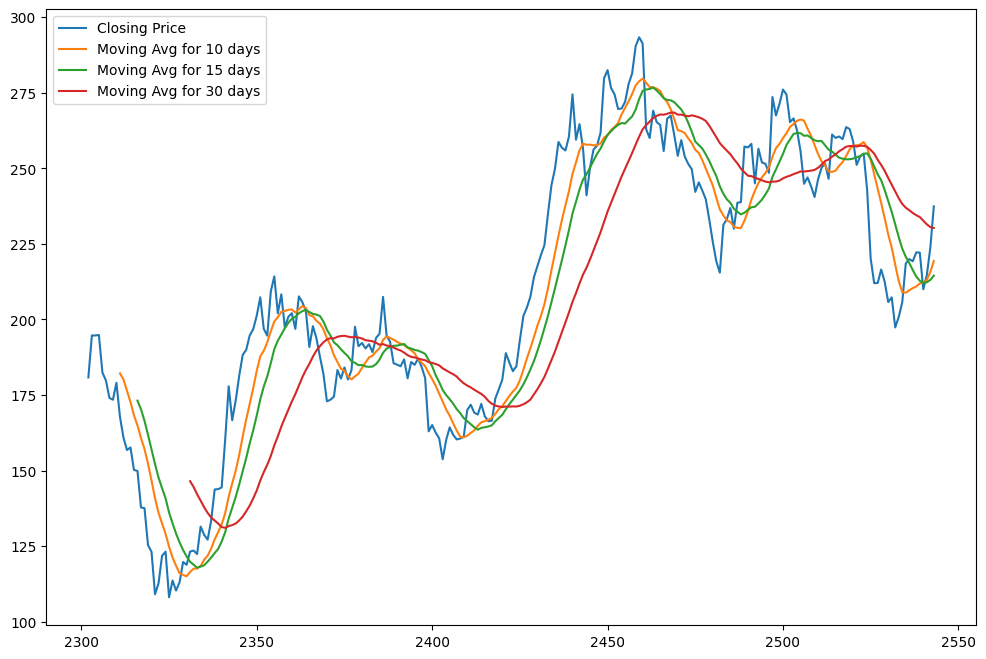

In [45]:
naive_ts_models = NaiveTimeSeriesModels(stock_name="Tesla, Inc", stock_data=tesla_df)
naive_ts_models.train_moving_average_model()